# Usable Data Mask (UDM2) Visualization and Masking

The Usable Data Mask (UDM2) is an iteration upon the Unusable Data Mask (UDM) product. It is available for many products and it contains the UDM as one of its bands. Specifications for the UDM2 are given in the [Imagery Spec Sheet](https://assets.planet.com/docs/combined-imagery-product-spec-april-2019.pdf) and the [UDM-2 API documentation](https://developers.planet.com/docs/api/udm-2/).

The UDM2 is a multi-band image. The first six bands are boolean bands that encode the absence or presence of different image usability concerns such as haze, clouds, and cloud shadows. The sixth band provides the confidence in the usability assessments as integer values between 0 and 100. The seventh band is the Unusable Data Mask, which is described in the Imagery Spec Sheet referenced above and explored in the [UDM notebook](../udm/udm.ipynb).

In this notebook, we demonstrate how to visualize the UDM2 bands and how to convert the UDM2 into two masks: masking all unclear pixels and masking cloud and shadow pixels.

## Install Dependencies and Set up Notebook

In [1]:
from collections import namedtuple, OrderedDict
import os

import matplotlib
import matplotlib.colors as colors
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import numpy as np
import rasterio

%matplotlib inline

## Define and Visualize Scene

The UDM2 asset is available for the `PSScene4Band` item-type. Not all PSScene4Band scenes have a UDM2 asset, so here we define the scene and item-type for the UDM2 asset.

In [2]:
scene_id = '20190321_174348_0f1a'
item_type = 'PSScene4Band'

## Visualize Metadata

Visualize the metadata for the scene `PSScene4Band` item-type.

In [3]:
# uncomment to see metadata fields
# !planet data search --item-type $item_type --string-in id $scene_id

Someday, fields will be added to the item `properties` that will allow for filtering on UDM2 values. Examples are `clear_percent` and `cloud_percent`. See the [WIP UDM2 documentation](http://planet-developer-center-website.s3-website-us-west-2.amazonaws.com/6d1845612d76a722f1e268e40cf88d2ecc6595e3/docs/api/udm-2/) for more fields. These metadata fields aren't yet present, so we will skip search and filtering of the UDM2 for now.

## Visualize Scene

In [4]:
# create the data folder if it doesn't exist
data_folder = 'data'
if not os.path.isdir(data_folder): os.mkdir(data_folder)

In [5]:
!planet data download --item-type $item_type \
                      --asset-type basic_analytic \
                      --string-in id $scene_id \
                      --dest data

activating: 0            complete: 0              elapsed: 0                    
paging: False            pending: 0                                             

activating: 0            complete: 0              elapsed: 1                    
paging: False            pending: 0                                             

activating: 1            complete: 0              downloaded: 0.00MB            
downloading: 0           elapsed: 2               paging: False                 
pending: 0                                                                      

activating: 1            complete: 0              downloaded: 0.00MB            
downloading: 0           elapsed: 2               paging: False                 
pending: 0                                                                      
2019-04-23 22:46:57,628 - FuturesSession - WARNING - `background_callback` is
deprecated and will be removed in 1.0, use `hooks` instead
activating: 0            complete: 0              

In [6]:
# store the scene filename for processing and make sure the file exists
scene_filename = os.path.join('data', scene_id + '_1B_AnalyticMS.tif')
print(scene_filename)
assert os.path.isfile(scene_filename)

data/20190321_174348_0f1a_1B_AnalyticMS.tif


In [7]:
# Utility functions: loading an image

NamedBands = namedtuple('NamedBands', 'b, g, r, nir')

def load_masked_bands(filename):
    """Loads a 4-band BGRNir Planet Image file as a list of masked bands.
    
    The masked bands share the same mask, so editing one band mask will
    edit them all."""
    with rasterio.open(filename) as src:
        b, g, r, nir = src.read()
        mask = src.read_masks(1) == 0 # 0 value means the pixel is masked
    
    bands = NamedBands(b=b, g=g, r=r, nir=nir)
    return NamedBands(*[np.ma.array(b, mask=mask)
                        for b in bands])

print(load_masked_bands(scene_filename).b.shape)

/opt/conda/lib/python3.6/site-packages/rasterio/__init__.py:217: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, **kwargs)


(2136, 6582)


In [8]:
# Utility functions: displaying an image

def _linear_scale(ndarray, old_min, old_max, new_min, new_max):
    """Linear scale from old_min to new_min, old_max to new_max.
    
    Values below min/max are allowed in input and output.
    Min/Max values are two data points that are used in the linear scaling.
    """
    #https://en.wikipedia.org/wiki/Normalization_(image_processing)
    return (ndarray - old_min)*(new_max - new_min)/(old_max - old_min) + new_min
# print(linear_scale(np.array([1,2,10,100,256,2560, 2660]), 2, 2560, 0, 256))

def _mask_to_alpha(bands):
    band = np.atleast_3d(bands)[...,0]
    alpha = np.zeros_like(band)
    alpha[~band.mask] = 1
    return alpha

def _add_alpha_mask(bands):
    return np.dstack([bands, _mask_to_alpha(bands)])

def bands_to_display(bands, alpha=True):
    """Converts a list of bands to a 3-band rgb, normalized array for display."""
    rgb_bands = np.dstack(bands[:3])

    old_min = np.percentile(rgb_bands, 2)
    old_max = np.percentile(rgb_bands, 98)
    new_min = 0
    new_max = 1
    scaled = _linear_scale(rgb_bands.astype(np.double),
                           old_min, old_max, new_min, new_max)
    bands = np.clip(scaled, new_min, new_max)
    if alpha is True:
        bands = _add_alpha_mask(bands)
    return bands

/opt/conda/lib/python3.6/site-packages/rasterio/__init__.py:217: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, **kwargs)


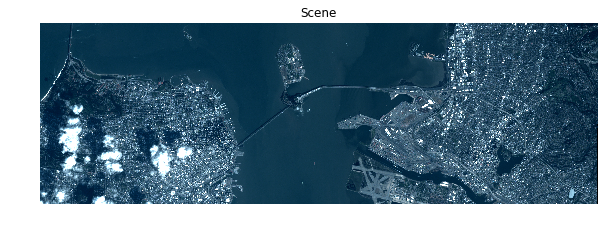

In [9]:
fig = plt.figure(figsize=(10, 10))
bands = load_masked_bands(scene_filename)
plt.imshow(bands_to_display([bands.r, bands.g, bands.b]))

plt.title('Scene')
ax = plt.axis('off')

## Download UDM2

To download the UDM2, we use the planet CLI because it handles activating, waiting for activation, and downloading the file.

We will save the UDM2 in the data folder. This folder isn't tracked by git so the downloaded image file will not bloat our git repository.

In [10]:
!planet data download --item-type $item_type \
                      --asset-type udm2 \
                      --string-in id $scene_id \
                      --dest data

activating: 0            complete: 0              elapsed: 0                    
paging: False            pending: 0                                             

activating: 1            complete: 0              downloaded: 0.00MB            
downloading: 0           elapsed: 1               paging: True                  
pending: 0                                                                      

activating: 1            complete: 0              downloaded: 0.00MB            
downloading: 0           elapsed: 2               paging: False                 
pending: 0                                                                      

activating: 1            complete: 0              downloaded: 0.00MB            
downloading: 0           elapsed: 2               paging: False                 
pending: 0                                                                      
2019-04-23 22:47:14,905 - FuturesSession - WARNING - `background_callback` is
deprecated and will be remov

In [11]:
# store the udm2 filename for processing and make sure the file exists
udm2_filename = os.path.join('data', scene_id + '_cloud_map.tif')
print(udm2_filename)
assert os.path.isfile(udm2_filename)

data/20190321_174348_0f1a_cloud_map.tif


## Load UDM2

In this section, we implement functionality for loading the UDM2 and identifying the bands. We load the UDM2 used in this notebook and determine the percentage of pixels that are clear of any usability concerns.

In [12]:
# Utility functions for loading a UDM2 image and identify bands as
# class labels
def load_udm2(udm2_filename):
    '''Load multi-band UDM2 as a 3d array.'''
    with rasterio.open(udm2_filename, 'r') as src:
        udm2 = src.read()
    return udm2

udm2_labels = ['clear', 'snow', 'shadow', 'light haze', 'heavy haze', 'cloud',
               'confidence', 'unusable pixels']

udm2 = load_udm2(udm2_filename)
print(udm2.shape)
print(udm2_labels)

(8, 4213, 8341)
['clear', 'snow', 'shadow', 'light haze', 'heavy haze', 'cloud', 'confidence', 'unusable pixels']


In [13]:
num_pixels = np.size(udm2[0,:])
num_clear = np.count_nonzero(udm2[0,:])
            
percent_clear = 100 * (num_pixels - num_clear) / num_pixels
print("{0:.01f}% of pixels are considered 'clear'".format(percent_clear))

44.4% of pixels are considered 'clear'


# Visualize UDM2

### Visualizing a Classified Band

In this section we develop the capability to visualize a classified band, as UDM2 bands are classified bands.

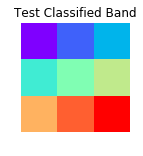

In [14]:
def plot_classified_band(class_band, class_labels=None,
                         cmap='rainbow',
                         title='Class Labels', figdim=10):

    fig = plt.figure(figsize=(figdim, figdim))
    ax = fig.add_subplot(1, 1, 1)
    imshow_class_band(ax, class_band, class_labels=class_labels, cmap=cmap)
    ax.set_title(title)
    ax.set_axis_off()

def imshow_class_band(ax, class_band, class_labels=None, cmap='rainbow'):
    """Show classified band with colormap normalization and color legend.
    Alters ax in place.
    
    possible cmaps ref:
    https://matplotlib.org/examples/color/colormaps_reference.html
    """
    class_norm = _ClassNormalize(class_band)
    im = ax.imshow(class_band, cmap=cmap, norm=class_norm)

    try:
        # add class label legend
        # https://stackoverflow.com/questions/25482876
        # /how-to-add-legend-to-imshow-in-matplotlib
        color_mapping = class_norm.mapping
        colors = [im.cmap(color_mapping[k])
                  for k in class_labels.keys()]
        labels = class_labels.values()

        # https://matplotlib.org/users/legend_guide.html
        # tag: #creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
        patches = [mpatches.Patch(color=c, label=l)
                   for c,l in zip(colors, labels)]

        ax.legend(handles=patches, bbox_to_anchor=(1, 1),
                  loc='upper right', borderaxespad=0.)
    except AttributeError:
        # class_labels not specified
        pass

# Inspired by
# https://matplotlib.org/users/colormapnorms.html#custom-normalization-two-linear-ranges
class _ClassNormalize(colors.Normalize):
    """Matplotlib colormap normalizer for a classified band.
    """
    def __init__(self, arry):
        # get unique unmasked values
        values = [v for v in np.unique(arry)
                  if not isinstance(v, np.ma.core.MaskedConstant)]

        # map unique values to points in the range 0-1
        if len(values) > 1:
            color_ticks = np.array(range(len(values)), dtype=np.float) / (len(values) - 1)
        else:
            color_ticks = np.array([0])

        self._mapping = dict((v, ct) for v, ct in zip(values, color_ticks))
        
        # Initialize base Normalize instance
        vmin = 0
        vmax = 1
        clip = False
        colors.Normalize.__init__(self, vmin, vmax, clip)
    
    def __call__(self, arry, clip=None):
        '''Create classified representation of arry for display.'''
        # round array back to ints for logical comparison
        arry = np.around(arry)
        new_arry = arry.copy()
        for k, v in self._mapping.items():
            new_arry[arry==k] = v
        return new_arry
    
    @property
    def mapping(self):
        '''property required for colors.Normalize classes
        
        We update the _mapping property in __init__ and __call__ and just
        return that property here.
        '''
        return self._mapping
    
# test out classified band visualization
test_classified_band = np.array(range(9)).reshape((3,3))
plot_classified_band(test_classified_band, title='Test Classified Band',
                     figdim=2)

### Visualize UDM2 Bands

The UDM2 product consists of multiple bands. The first six bands are boolean, present/absent. The seventh band is greyscale, and the eighth is the original bit-encoded UDM.

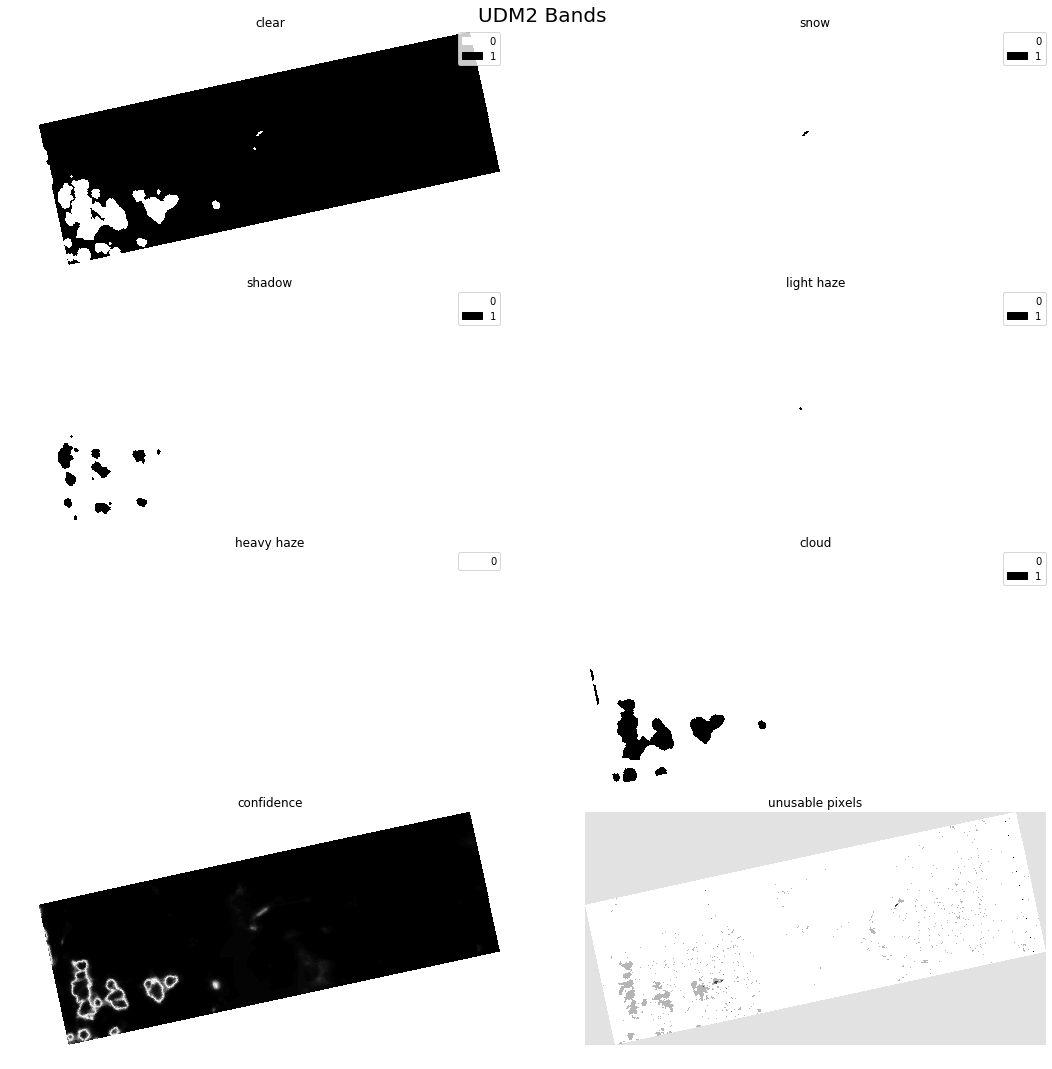

In [15]:
def visualize_udm2(udm2, figsize=(15,15)):
    fig, axes = plt.subplots(nrows=4, ncols=2,
                                   sharex=True, sharey=True,
                                   figsize=figsize,
                            constrained_layout=True)
    
    bands = [np.squeeze(b) for b in 
             np.split(udm2, udm2.shape[0], axis=0)]
    band_labels = udm2_labels

    fig.suptitle('UDM2 Bands', fontsize=20)
    bal = zip(bands, axes.flat, udm2_labels)
    for i, (band, ax, label) in enumerate(bal):
        unique = np.unique(band)
    
        # it is unwieldy to show a legend for more than 5 values
        if len(unique) < 5:
            class_labels = OrderedDict((v, v) for v in np.unique(band))
        else:
            class_labels = None
        imshow_class_band(ax, band, class_labels=class_labels, cmap='Greys')
        ax.set_title(label)
        ax.set_axis_off()

visualize_udm2(udm2)

The clear band is a combination of all of the other bands. It identifies the snow, clouds, cloud shadows, and light and heavy haze. There appears to be no heavy haze and just a touch of light haze and snow. Really, though, this is a picture of San Francisco, so light haze is possible but snow is unlikely.

### Visualize UDM2 Unusable Data Mask Band

The Unusable Data Mask band of the UDM2 is the original UDM. It is a bit-encoded representation of whether a pixel is usable and, if not, why. Let's check out the usability of the pixels in this image. This section pulls functionality from the [UDM notebook](udm.ipynb).

In [16]:
def get_udm_labels(udm):
    '''Get the interpretation of the UDM binary values'''    
    def get_label(v):
        if v == 0:
            label = 'clear'
        elif v == 1:
            label = 'blackfill'
        else:
            labels = []
            if v & int('10',2):
                labels.append('cloud')
            if v & int('1111100',2):
                bands = []
                if v & int('100',2):
                    bands.append('Blue')
                if v & int('1000', 2):
                    bands.append('Green')
                if v & int('10000', 2):
                    bands.append('Red')
                if v & int('100000', 2):
                    bands.append('Red-Edge')
                if v & int('1000000', 2):
                    bands.append('NIR')
                labels.append('missing/suspect {} data'.format(', '.join(bands)))
                
            if not len(labels):
                labels.append('{0:08b}'.format(v))

            label = ', '.join(labels)
        return label

    return OrderedDict((v, get_label(v)) for v in np.unique(udm))

udm2_udm = udm2[-1, ...]
print('Labels present in this UDM2 UDM band')
get_udm_labels(udm2_udm)

Labels present in this UDM2 UDM band


OrderedDict([(0, 'clear'),
             (1, 'blackfill'),
             (2, 'cloud'),
             (28, 'missing/suspect Blue, Green, Red data'),
             (30, 'cloud, missing/suspect Blue, Green, Red data'),
             (64, 'missing/suspect NIR data')])

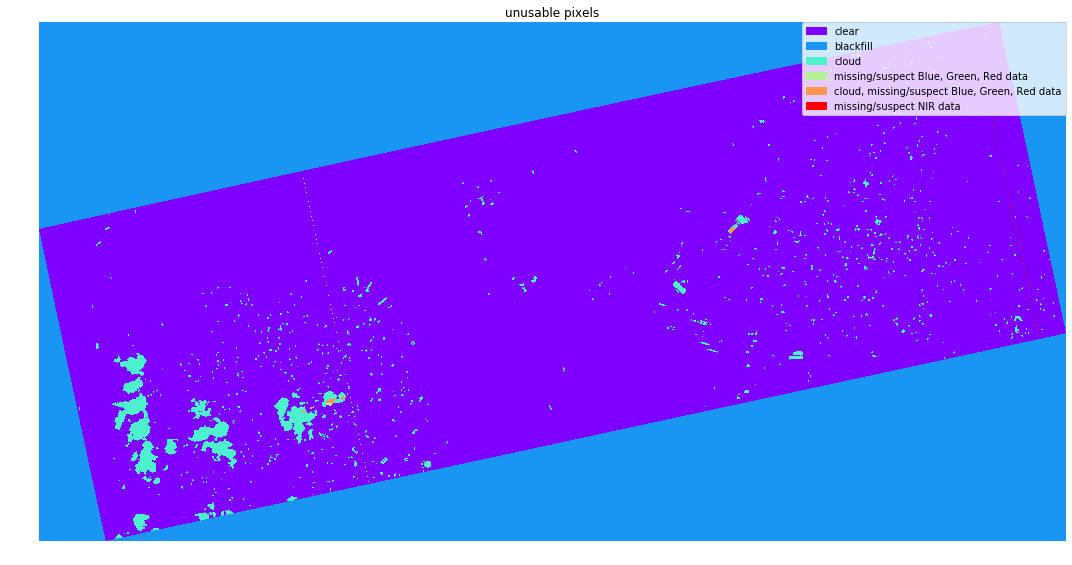

In [17]:
def visualize_udm2_unusable(udm2, figsize=(15,15)):
    '''Visualize the unusable data mask band of the UDM2 product.'''
    fig, ax = plt.subplots(nrows=1, ncols=1,
                                   sharex=True, sharey=True,
                                   figsize=figsize)
    band = udm2[-1, :]
    label = udm2_labels[-1]

    imshow_class_band(ax, band, class_labels=get_udm_labels(band), cmap='rainbow')
    ax.set_title(label)
    ax.set_axis_off()

    plt.tight_layout()

visualize_udm2_unusable(udm2)

Most of the pixels within the footprint of the image are usable (purple). Most of those that aren't usable are identified as clouds (teal). Just a few pixels have suspect RGB data, likely due to saturation.

## Convert UDM2 to Mask

Converting the UDM2 to a binary mask is pretty straightforward. If one is just interested in only the 'clear' pixels, then they can use the first band of the UDM2 (clear band). The same can be said for avoiding 'cloud' pixels, 'haze' pixels, etc. Masking cloud and cloud shadow pixels is a little more complicated, but still pretty simple. Here, we show how to create a mask that masks all unclear pixels and how to create a mask that masks all cloud and shadow pixels.

### Mask all unclear pixels

In [21]:
mask_class_labels = {0: 'unmasked', 1: 'masked'}
mask_cmap = 'viridis' # looks better when just two colors are displayed

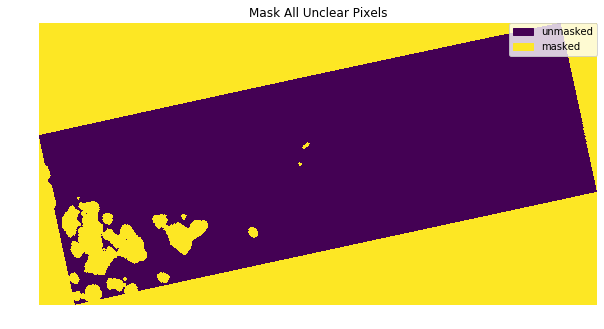

In [24]:
def mask_unclear(udm2_array):
    '''Create a mask from the udm2, masking all unclear pixels''' 
    return udm2_array[0,...] == 0

plot_classified_band(mask_unclear(udm2),
                     class_labels=mask_class_labels,
                     cmap=mask_cmap,
                     title='Mask All Unclear Pixels')

### Mask cloud and shadow pixels

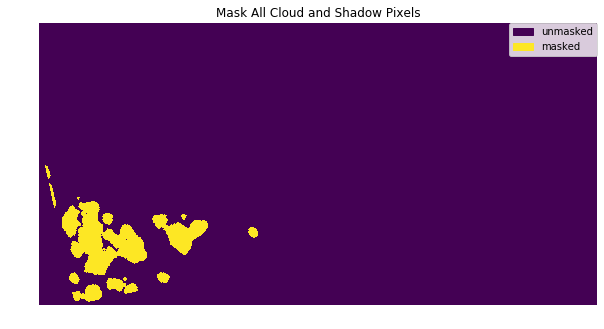

In [30]:
def mask_cloud_shadow(udm2_array):
    '''Create a mask from the udm2, masking all cloud and cloud shadow pixels'''
    shadow_band = udm2_array[2,...]
    cloud_band = udm2_array[5,...]
    masked_pixels = np.logical_or(shadow_band == 1, cloud_band == 1)
    return masked_pixels

plot_classified_band(mask_cloud_shadow(udm2),
                     class_labels=mask_class_labels,
                     cmap=mask_cmap,
                     title='Mask All Cloud and Shadow Pixels')